In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import glob

# 1. 自动查找并加载目录中的所有记录文件
def load_all_records_from_dir(data_dir, max_records=None):
    all_beats = []
    all_labels = []
    
    # 查找所有具有.dat和.atr文件的记录
    dat_files = glob.glob(os.path.join(data_dir, "*.dat"))
    record_names = [os.path.splitext(os.path.basename(f))[0] for f in dat_files]
    
    print(f"找到 {len(record_names)} 个记录文件")
    
    # 限制加载的记录数量，以避免内存问题
    if max_records and len(record_names) > max_records:
        record_names = record_names[:max_records]
        print(f"限制加载前 {max_records} 个记录")
    
    for record_name_base in record_names:
        try:
            # 构建完整路径（不带扩展名）
            record_path = os.path.join(data_dir, record_name_base)
            
            # 检查是否同时存在.dat和.atr文件
            if (os.path.exists(record_path + '.dat') and 
                os.path.exists(record_path + '.atr')):
                
                # 读取信号和注释
                record = wfdb.rdrecord(record_path)
                annotation = wfdb.rdann(record_path, 'atr')
                
                # 获取信号数据
                signal = record.p_signal
                
                # 从注释中获取R波位置
                r_peaks = annotation.sample
                
                # 提取每个心跳的窗口
                window_size = 300  # 大约0.83秒 (在360Hz采样率下)
                
                beats_from_record = 0
                for i, peak in enumerate(r_peaks):
                    # 确保窗口不会超出信号范围
                    if peak >= window_size//2 and peak < len(signal) - window_size//2:
                        # 提取窗口（使用第一个通道）
                        beat = signal[peak-window_size//2:peak+window_size//2, 0]
                        all_beats.append(beat)
                        all_labels.append(annotation.symbol[i])
                        beats_from_record += 1
                
                print(f"成功加载记录 {record_name_base}，提取了 {beats_from_record} 个心跳")
                
            else:
                print(f"跳过 {record_name_base}：缺少必要的文件")
                
        except Exception as e:
            print(f"加载记录 {record_name_base} 时出错: {e}")
    
    return np.array(all_beats), all_labels

    
class ECGLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(ECGLSTMModel, self).__init__()
        # 修正LSTM参数，移除return_sequences参数
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        # 修改forward方法以适应PyTorch LSTM的输出格式
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        # 在第二个LSTM中，我们只使用最后一个时间步的输出
        out, _ = self.lstm2(out)
        out = self.dropout2(out[:, -1, :])  # 只取最后一个时间步
        out = self.fc(out)
        return out

In [2]:
def main():
    # 设置记录文件目录
    data_dir = r"D:\25spring\wednesday\6\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0"
    
    # 加载目录中的记录文件(限制数量以避免内存问题)
    beats, labels = load_all_records_from_dir(data_dir, max_records=48)  # 可以调整数字
    
    if len(beats) == 0:
        print("未能加载任何心跳数据，请检查数据目录和文件格式")
        return
    
    # 数据统计
    print(f"\n总共加载了 {len(beats)} 个心跳样本")
    unique_labels = list(set(labels))
    print(f"类别数: {len(unique_labels)}")
    print("各类别统计:")
    for label in unique_labels:
        count = labels.count(label)
        print(f"  {label}: {count} ({count/len(labels)*100:.2f}%)")
    
    # 将标签转换为数字
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_map[label] for label in labels])
    
    # 数据预处理：归一化
    scaler = MinMaxScaler()
    beats_normalized = np.array([scaler.fit_transform(beat.reshape(-1, 1)).flatten() for beat in beats])
    
    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(
        beats_normalized, numeric_labels, test_size=0.2, random_state=42, stratify=numeric_labels
    )
    
    # 将数据转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))
    X_test_tensor = torch.FloatTensor(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)
    
    # 创建数据加载器
    batch_size = 32  # 减小批量大小以降低内存需求
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 初始化模型
    input_size = 1
    hidden_size1 = 64
    hidden_size2 = 32
    output_size = len(unique_labels)
    
    model = ECGLSTMModel(input_size, hidden_size1, hidden_size2, output_size)
    
    # 计算类别权重以处理类别不平衡
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / np.sum(class_weights) * len(class_counts)
    class_weights_tensor = torch.FloatTensor(class_weights)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 检查是否有GPU可用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"\n使用设备: {device}")
    model.to(device)
    if torch.cuda.is_available():
        class_weights_tensor = class_weights_tensor.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        
    # 记录训练过程中的损失值和准确率
    train_losses = []
    val_accuracies = []
    
    # 训练模型
    num_epochs = 100  # 训练轮数
    print("\n开始训练...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_losses.append(total_loss / len(train_loader))  # 记录损失值
        
        # 计算验证准确率
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())  # 收集所有预测值
                all_labels.extend(targets.cpu().numpy())  # 收集所有真实标签
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)  # 记录验证准确率
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # 训练完成后绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    loss_curve_path = r"D:\25spring\wednesday\6\training_loss_curve.png"
    plt.savefig(loss_curve_path)
    loss_curve_img = plt.gcf()
    plt.show()

    # 计算并绘制混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = ['S', 'A', 'a', '"', 'L', 'F', '|', 'f', '/', 'N', 'e', '!', 'V', ']', '+', 'x', 'E', '[', 'j', 'J', 'Q', 'R', '~']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 10}, cbar_kws={'label': 'Counts'}, square=True)

    # Adjust axis labels for better spacing
    plt.xticks(rotation=90, ha='center', fontsize=12)
    plt.yticks(rotation=0, ha='center', fontsize=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    confusion_matrix_path = r"D:\25spring\wednesday\6\confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    confusion_matrix_img = plt.gcf()
    plt.show()

#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     confusion_matrix_path = r"D:\25spring\wednesday\6\confusion_matrix.png"
#     plt.savefig(confusion_matrix_path)
#     confusion_matrix_img = plt.gcf()
#     plt.show()

    # 保存模型
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_map': label_map,
        'window_size': 300,
    }, 'lstm_model.pth')
    print("\n模型已保存到 lstm_model.pth")

#     # 训练模型
#     num_epochs = 100  # 减少训练轮数
#     print("\n开始训练...")
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
        
#         for inputs, targets in train_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()
        
#         train_accuracy = correct / total
        
#         # 计算验证准确率
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, targets in test_loader:
#                 inputs, targets = inputs.to(device), targets.to(device)
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += targets.size(0)
#                 correct += (predicted == targets).sum().item()
        
#         val_accuracy = correct / total
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
    
#     # 保存模型
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'label_map': label_map,
#         'window_size': 300,
#     }, 'ecg_lstm_model.pth')
#     print('\n模型已保存到 ecg_lstm_model.pth')

# if __name__ == "__main__":
#     main()

找到 48 个记录文件
成功加载记录 100，提取了 2271 个心跳
成功加载记录 101，提取了 1872 个心跳
成功加载记录 102，提取了 2189 个心跳
成功加载记录 103，提取了 2089 个心跳
成功加载记录 104，提取了 2308 个心跳
成功加载记录 105，提取了 2690 个心跳
成功加载记录 106，提取了 2097 个心跳
成功加载记录 107，提取了 2138 个心跳
成功加载记录 108，提取了 1822 个心跳
成功加载记录 109，提取了 2532 个心跳
成功加载记录 111，提取了 2132 个心跳
成功加载记录 112，提取了 2547 个心跳
成功加载记录 113，提取了 1794 个心跳
成功加载记录 114，提取了 1889 个心跳
成功加载记录 115，提取了 1960 个心跳
成功加载记录 116，提取了 2420 个心跳
成功加载记录 117，提取了 1537 个心跳
成功加载记录 118，提取了 2299 个心跳
成功加载记录 119，提取了 2093 个心跳
成功加载记录 121，提取了 1874 个心跳
成功加载记录 122，提取了 2476 个心跳
成功加载记录 123，提取了 1517 个心跳
成功加载记录 124，提取了 1632 个心跳
成功加载记录 200，提取了 2790 个心跳
成功加载记录 201，提取了 2038 个心跳
成功加载记录 202，提取了 2145 个心跳
成功加载记录 203，提取了 3105 个心跳
成功加载记录 205，提取了 2670 个心跳
成功加载记录 207，提取了 2383 个心跳
成功加载记录 208，提取了 3037 个心跳
成功加载记录 209，提取了 3050 个心跳
成功加载记录 210，提取了 2682 个心跳
成功加载记录 212，提取了 2761 个心跳
成功加载记录 213，提取了 3291 个心跳
成功加载记录 214，提取了 2294 个心跳
成功加载记录 215，提取了 3397 个心跳
成功加载记录 217，提取了 2279 个心跳
成功加载记录 219，提取了 2312 个心跳
成功加载记录 220，提取了 2066 个心跳
成功加载记录 221，提取了 2461 个心跳
成功加载记录 222，提取了 2631 个心跳
成功加载

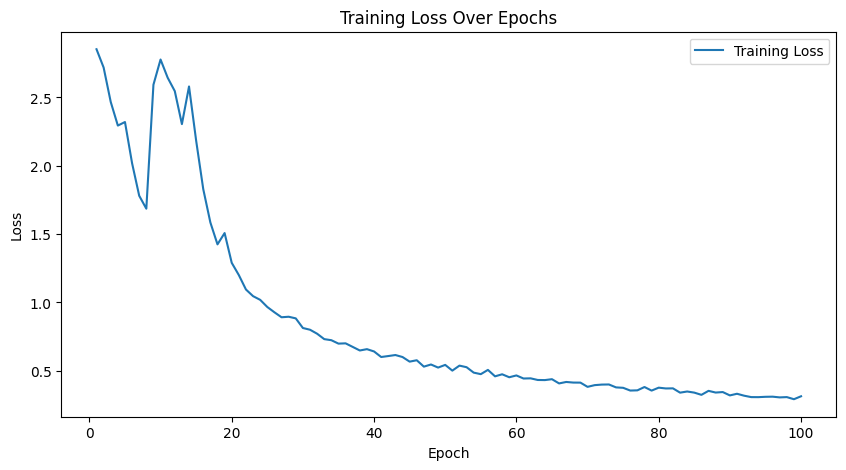

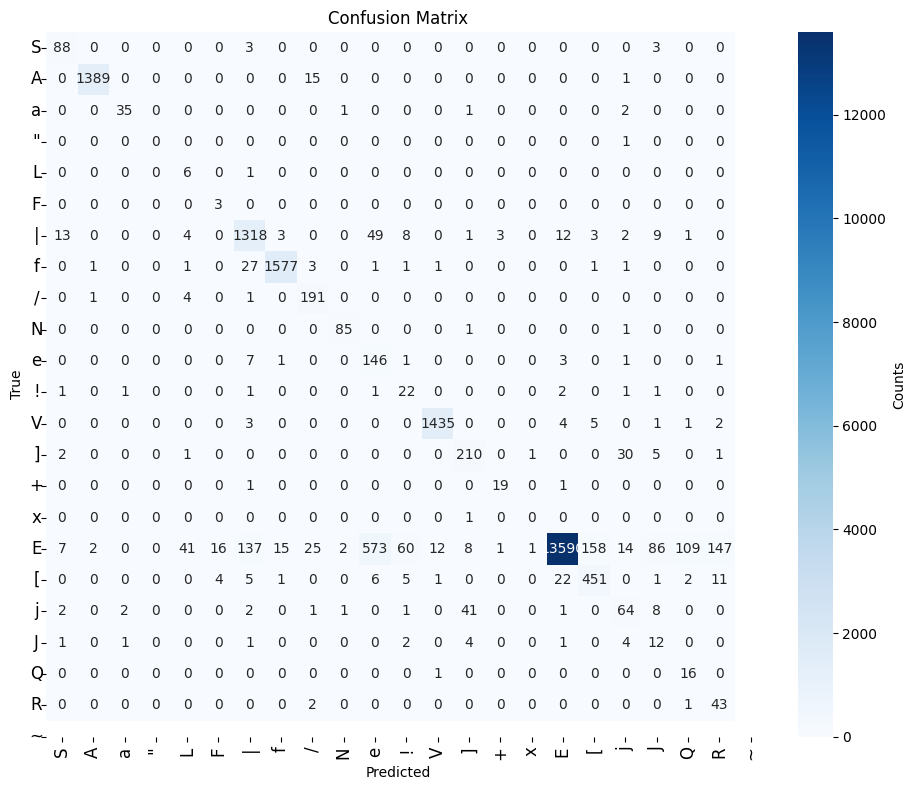


模型已保存到 lstm_model.pth


In [3]:
if __name__ == "__main__":
    main()